In [1]:
import numpy as np
import sklearn.decomposition
import imblearn
from pathlib import Path
import tqdm
from datetime import datetime
from massimal import hyspec_io, annotation, hyspec_ml
import json
import matplotlib.pyplot as plt

In [2]:
# Paths
hyspec_base = Path('/home/mha114/data/massimal/vega_sola/hyperspec/images/2a_rrs/')
class_json = Path('/home/mha114/data/massimal/vega_sola/hyperspec/annotation/v2.1/png_gray/label_classes.json')
class_hierarchy_json = Path("/home/mha114/code/github/massimal/annotation/massimal_annotation_class_hierarchy.json")
pca_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/pca_models')
spectra_file = Path('/home/mha114/data/massimal/vega_sola/hyperspec/sampled_spectra/sola_sampled_spectra_v1/20220823_Vega_Sola_ExtractedSpectraAndLabels2024-04-27-18h25m55s.npz')

pca_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime('%Y-%m-%d-%Hh%Mm%Ss')
pca_model_path = pca_dir / f'vega_sola_pca_model_original_class_dist_{timestamp}.npz'


In [3]:
# Parameters
wl_max = 730
wl_min = 400
minimum_reflectance = 0.001

In [4]:
# Get wavelengths from example hyspec file
example_hyspec_file_path = [path for path in sorted(hyspec_base.rglob('*.hdr'))][0]
_,wl,_,_ = hyspec_io.load_envi_image(str(example_hyspec_file_path),rgb_only=True)

In [5]:
# Load data
with np.load(spectra_file) as npz_files:
    X_raw = npz_files['X']
    y_raw = npz_files['y']

In [6]:
# Remove zero-valued spectra (caused by saturation)
nonzero_spectra_mask = ~np.all(X_raw==0,axis=1)
X = X_raw[nonzero_spectra_mask,:]
y = y_raw[nonzero_spectra_mask]

In [7]:
# Ensure non-zero reflectances (better behavior when taking logarithm)
X[X<minimum_reflectance] = minimum_reflectance

In [8]:
# Load class names and indices
class_indices = annotation.read_hasty_metadata(class_json)
class_names = {value:key for key,value in class_indices.items()}

In [9]:
# Inspect number of samples per class
for class_name, class_index in class_indices.items():
    print(f'{class_name:25} {class_index:3} {np.count_nonzero(y==class_index)} samples')

Deep water                  1 7820 samples
Substrate                   2 0 samples
Rock                        3 0 samples
Bedrock                     4 238020 samples
Boulder                     5 0 samples
Cobble                      6 109289 samples
Gravel                      7 0 samples
Sediment                    8 0 samples
Sand                        9 422989 samples
Mud                        10 0 samples
Algae                      11 0 samples
Brown algae                12 379991 samples
Kelp                       13 16502 samples
Laminaria hyperborea       14 45185 samples
Laminaria digitata         15 0 samples
Sacchoriza polyides        16 1170 samples
Saccharina latissima       17 1539 samples
Alaria esculenta           18 0 samples
Rockweed                   19 162672 samples
Rockweed, hydrolittoral    20 0 samples
Ascophyllum nodosum        21 0 samples
Fucus vesiculosus          22 0 samples
Fucus serratus             23 0 samples
Halidrys siliquosa         24 31610 sa

In [10]:
# Load class hierarchy
with open(class_hierarchy_json,'r') as file:
    class_hierarchy = json.load(file)
print(class_hierarchy)

{'Deep water': [], 'Algae': {'Brown algae': {'Kelp': ['Laminaria hyperborea', 'Laminaria digitata', 'Sacchoriza polyides', 'Saccharina latissima', 'Alaria esculenta'], 'Rockweed': {'Rockweed, hydrolittoral': ['Ascophyllum nodosum', 'Fucus vesiculosus', 'Fucus serratus', 'Halidrys siliquosa'], 'Rockweed, geolittoral': ['Fucus spiralis', 'Pelvetia canaliculata']}, 'Brown algae, other': ['Chorda filum', 'Desmarestia aculeata']}, 'Red algae': {'Coralline algae': ['Maerl']}, 'Green algae': [], 'Turf': []}, 'Substrate': {'Rock': ['Bedrock', 'Boulder', 'Cobble', 'Gravel'], 'Sediment': ['Sand', 'Mud']}, 'Animals': {'Mussels': ['Mytilus edilus']}, 'Human activity': ['Trawl track']}


In [11]:
# Define grouped classes
grouped_classes = ['Sand','Bedrock','Cobble','Maerl','Rockweed','Kelp','Chorda filum']
grouped_class_indices = annotation.class_indices_from_hierarchy(class_hierarchy,class_indices,grouped_classes)
grouped_class_indices['Brown algae (deep)'] = {class_indices['Brown algae']}
print(grouped_class_indices)

{'Sand': {9}, 'Bedrock': {4}, 'Cobble': {6}, 'Maerl': {33}, 'Rockweed': {19, 20, 21, 22, 23, 24, 25, 26, 27}, 'Kelp': {13, 14, 15, 16, 17, 18}, 'Chorda filum': {29}, 'Brown algae (deep)': {12}}


In [12]:
# Create "grouped" y vector
y_grouped = np.zeros_like(y)
for i, group_name in enumerate(grouped_class_indices.keys()):
    for ci in grouped_class_indices[group_name]:
        y_grouped[y==ci] = i+1

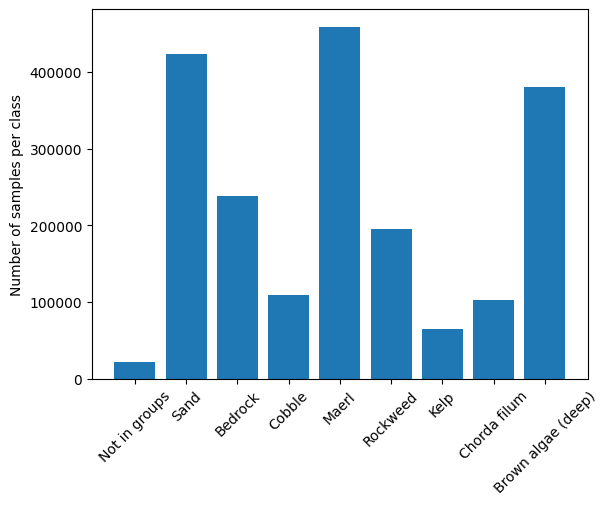

In [13]:
# Class histogram
y_grouped_values = np.unique(y_grouped)
sample_count = [np.count_nonzero(y_grouped==ygv) for ygv in y_grouped_values]
plt.bar(y_grouped_values,sample_count)
bar_tick_labels = ['Not in groups']+[k for k in grouped_class_indices.keys()]
plt.xticks(y_grouped_values,bar_tick_labels,rotation=45)
plt.ylabel('Number of samples per class')
plt.show()

In [14]:
print('Not included in any groups:')
for not_in_group_ind in np.unique(y[y_grouped==0]):
    print(f'  - {class_names[not_in_group_ind]} ({np.count_nonzero(y==not_in_group_ind)} samples)')

Not included in any groups:
  - Deep water (7820 samples)
  - Desmarestia aculeata (7204 samples)
  - Turf (6761 samples)


In [15]:
# Limit to wavelength range and convert to logarithmic spectra
wl_ind = (wl>= wl_min) & (wl<= wl_max)
X_log = np.log10(X[:,wl_ind])
print(X_log.shape)

(1992998, 159)


In [16]:
# Create PCA model
pca = sklearn.decomposition.PCA(n_components=30)
_ = pca.fit(X_log)

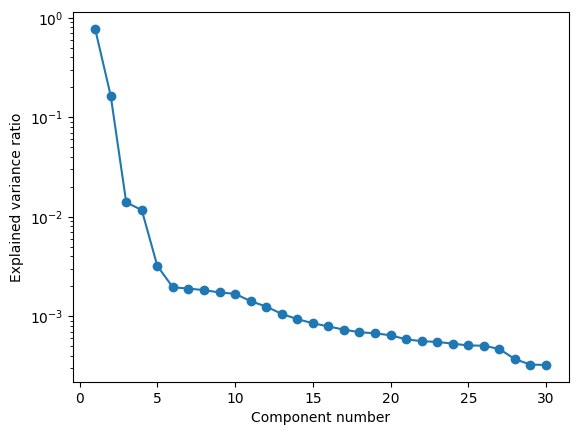

In [17]:
# Plot explained variance ratio
plt.semilogy(np.arange(1,pca.n_components+1),pca.explained_variance_ratio_,'-o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component number')
plt.show()

In [18]:
print(f'Explained variance using 5 components (in log-domain): {np.sum(pca.explained_variance_ratio_[0:5])*100:.2f} %')

Explained variance using 5 components (in log-domain): 96.50 %


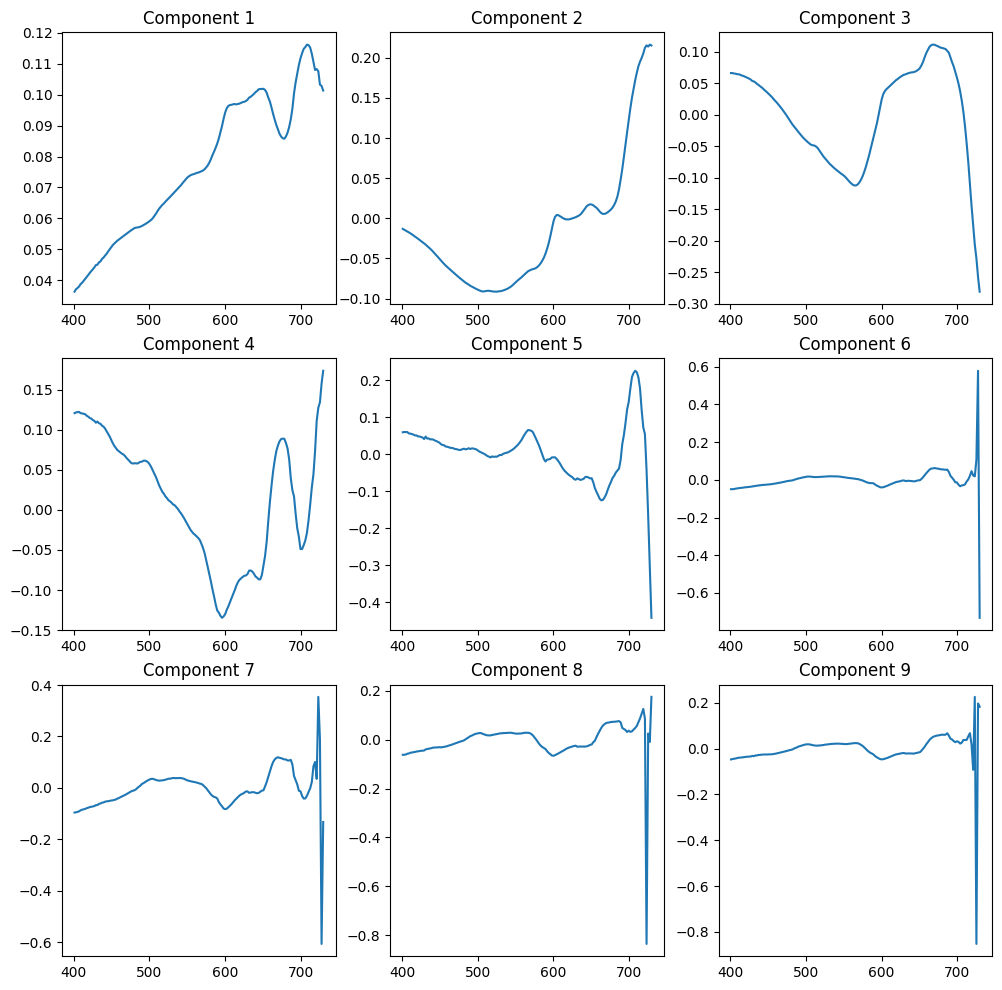

In [19]:
# Plot first components
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(12,12))
for i,component in enumerate(pca.components_[0:9]):
    ax[i//3][i%3].plot(wl[wl_ind],component)
    ax[i//3][i%3].title.set_text(f'Component {i+1}')

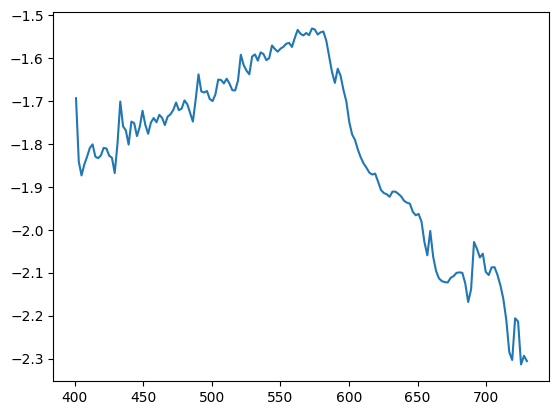

In [20]:
# Plot mean vector
plt.plot(wl[wl_ind],pca.mean_)
plt.show()

In [21]:
# Save model
hyspec_ml.save_pca_model(pca,X_log,npz_filename=pca_model_path,n_components=10,feature_labels=wl[wl_ind])
# # Save wavelengths
# wl_savename = pca_model_path.parent / (pca_model_path.stem + '_wl.npz')
# np.savez(npz_filename)

In [22]:
# Load saved model (check that saving was successful)
W_pca,X_mean_loaded,_,feature_labels = hyspec_ml.read_pca_model(pca_model_path,include_feature_labels=True)

In [27]:
assert np.allclose(pca.components_[0:W_pca.shape[0]],W_pca,rtol=1e-2)  # Almost equal - PCA not always the same?
assert np.allclose(pca.mean_, X_mean_loaded)
assert np.allclose(wl[wl_ind], feature_labels)